# 0 Table of Contents

1. [Setup](#1-setup)
    1. [Import](#11-imports)
    2. [Resources](#12-resources)
    3. [Load Data](#13-load-data)
2. [Prepare Data](#2-prepare-data)
3. [KMeans](#3-kmeans)
    1. [Functions](#31-functions)
    2. [Find Appropriate Variables](#32-find-appropriate-variables)
    3. [Visualize Results](#33-visualize-results)

# 1 Setup [(#)](#0-table-of-contents)

## 1.1 Imports [(#)](#0-table-of-contents)

In [1]:
import sys
import os
from  pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, r"C:\Users\vynde\PycharmProjects\dataanalysis")
import databridger as da 

## 1.2 Resources [(#)](#0-table-of-contents)

In [2]:
raw_data_folder = Path('..') / 'data' / 'raw'
report_folder = Path('..') / 'reports'

## 1.3 Load Data [(#)](#0-table-of-contents)

Load database with databriger

In [3]:
db_csv = da.Database(raw_data_folder)

Convert datetime variables

In [4]:
for key in db_csv.tables:
    for column in db_csv.tables[key].columns:
        if db_csv.tables[key][column].dtype == 'object':
            if all(db_csv.tables[key][column].str.match(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")):
                db_csv.tables[key][column] = pd.to_datetime(db_csv.tables[key][column])
                print(f"converted:   {key:15} / {column:30} from object to {db_csv.tables[key][column].dtype}")

converted:   olist_orders_dataset / order_purchase_timestamp       from object to datetime64[ns]
converted:   olist_orders_dataset / order_approved_at              from object to datetime64[ns]
converted:   olist_orders_dataset / order_delivered_carrier_date   from object to datetime64[ns]
converted:   olist_orders_dataset / order_delivered_customer_date  from object to datetime64[ns]
converted:   olist_orders_dataset / order_estimated_delivery_date  from object to datetime64[ns]
converted:   olist_order_items_dataset / shipping_limit_date            from object to datetime64[ns]
converted:   olist_order_reviews_dataset / review_creation_date           from object to datetime64[ns]
converted:   olist_order_reviews_dataset / review_answer_timestamp        from object to datetime64[ns]


Rename tables

In [5]:
table_names = list(db_csv.tables.keys())

# remove 'olist_' and '_dataset' in table_names
new_table_names = (
    list(map(
        lambda x: x.removeprefix("olist_").removesuffix("_dataset"), 
        table_names
    ))
)

# overwrite table names in db_csv
db_csv.tables = dict(zip(new_table_names, db_csv.tables.values()))

Overview

In [6]:
db_csv.update_columns_mapping(["geolocation_zip_code_prefix"])

Column and table mappings need to be corrected. Current implementation of the Database class for csv files does not construct a compatible columns_mapping for using its easy_merge method.

Therefore, table-column-pairs just need to be swapped and concatenated

In [7]:
# original mapping
df1 = db_csv.columns_mapping[["from_table", "from_column", "to_table", "to_column"]]
# swapped version
df2 = db_csv.columns_mapping[["to_table", "to_column", "from_table", "from_column"]]

# Renaming columns to match the df1's columns
df2.columns = ["from_table", "from_column", "to_table", "to_column"]

# new mapping
adjusted_columns_mapping = pd.concat([df1, df2], ignore_index=True).drop_duplicates()

# apply the new mapping to the Database instance
db_csv.columns_mapping = adjusted_columns_mapping

# this is copy/pasted from the Database class directly
db_csv.table_mapping = dict(db_csv.columns_mapping[["from_table", "to_table"]].groupby("from_table")["to_table"].apply(list))

# 2 Prepare Data [(#)](#0-table-of-contents)

Merge tables into one dataframe

In [8]:
table_names = ["orders", "order_items", "order_payments"]
tables = [db_csv.tables[table_name] for table_name in table_names]

for table in tables:
    print(table.shape, table.columns.tolist())

df = tables[0]
for table in tables[1:]:
    df = df.merge(table, how="outer")

print(df.shape)

(99441, 8) ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
(112650, 7) ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
(103886, 5) ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
(118434, 18)


Add some more columns

In [9]:
# order items
df["order_payment"] = df.groupby(["order_id", "order_item_id"])["payment_value"].transform("sum")
df["order_price"] = df.groupby(["order_id", "payment_sequential"])["price"].transform("sum")
df["order_freight"] = df.groupby(["order_id", "payment_sequential"])["freight_value"].transform("sum")
df["order_numitems"] = df.groupby("order_id")["order_item_id"].transform("max")
df["order_numpayments"] = df.groupby("order_id")["payment_sequential"].transform("max")

# orders
df["time_to_approve"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.days
df["time_to_carrier"] = (df["order_delivered_carrier_date"] - df["order_purchase_timestamp"]).dt.days
df["time_to_customer"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["time_to_customer_est"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days

In [10]:
df_order = df[[
    'order_numitems', 'order_numpayments', 'order_payment', 'order_price', 'order_freight',
    'time_to_customer', 'payment_installments'
]].dropna()

# 3 KMeans [(#)](#0-table-of-contents)

## 3.1 Functions [(#)](#0-table-of-contents)

Elbow Method

In [11]:
def kmeans_elbow(df):
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # List to store within-cluster sum of squares for each number of clusters
    wcss = []

    # Calculate WCSS for 1 to 10 clusters
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, 11), wcss)
    plt.title('\n'.join(['Elbow Method', *df.columns]))
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [12]:
def kmeans_elbow_xy(x, y, **kwargs):
    """Adjusted kmeans_elbow suitable for sns.PairGrid().map method"""
    
    # Standardize x and y data
    scaler = StandardScaler()
    df = pd.DataFrame([x, y]).T
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # List to store WCSS for each number of clusters
    wcss = []

    # Calculate WCSS for 1 to 10 clusters
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)

    # Adjust the WCSS curve to fit with the scatter plot scale
    wcss = np.array(wcss)
    x_line = np.linspace(min(x), max(x), 10)
    y_line = min(y) + ((wcss - min(wcss)) / (max(wcss) - min(wcss))) * (max(y) - min(y))

    # Plot the adjusted elbow curve on the scatter plot
    plt.plot(x_line, y_line, **kwargs)
    for i in range(10):
        plt.annotate(str(i+1), (x_line[i], y_line[i]))

Visualize Clusters

In [13]:
def kmeans_show(df, n_clusters=3):
    """Applies the KMeans algorithm to the columns of df visualizing the result in matrix form."""

    # Determine the number of columns in the dataframe
    num_columns = len(df.columns)

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Apply KMeans clustering to the standardized data
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(features_scaled)
    subset_labels = kmeans.labels_

    # Create a matrix of subplots
    n_grid = max([1, num_columns - 1])
    fig, axes_matrix = plt.subplots(n_grid, n_grid)

    # Plot each pair of features in the matrix
    for i, col_a in enumerate(df.columns):
        for j, col_b in enumerate(df.columns):
            if j > i:
                try:
                    ax = axes_matrix[i, j - 1]  # Adjust for the removed first column
                except TypeError:
                    ax = axes_matrix

                # Scatter plot of two features colored by cluster labels
                ax.scatter(features_scaled[col_a], features_scaled[col_b], c=subset_labels, s=10, alpha=0.3)
                ax.set_xlabel(f'{col_a} (scaled)')
                ax.set_ylabel(f'{col_b} (scaled)')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## 3.2 Find Appropriate Variables [(#)](#0-table-of-contents)

Scatterplots and elbow method applied to each pair of variables to find a suitable pair to apply the KMeans algorithm. Graphs with notable kinks indicate suitable pairs.

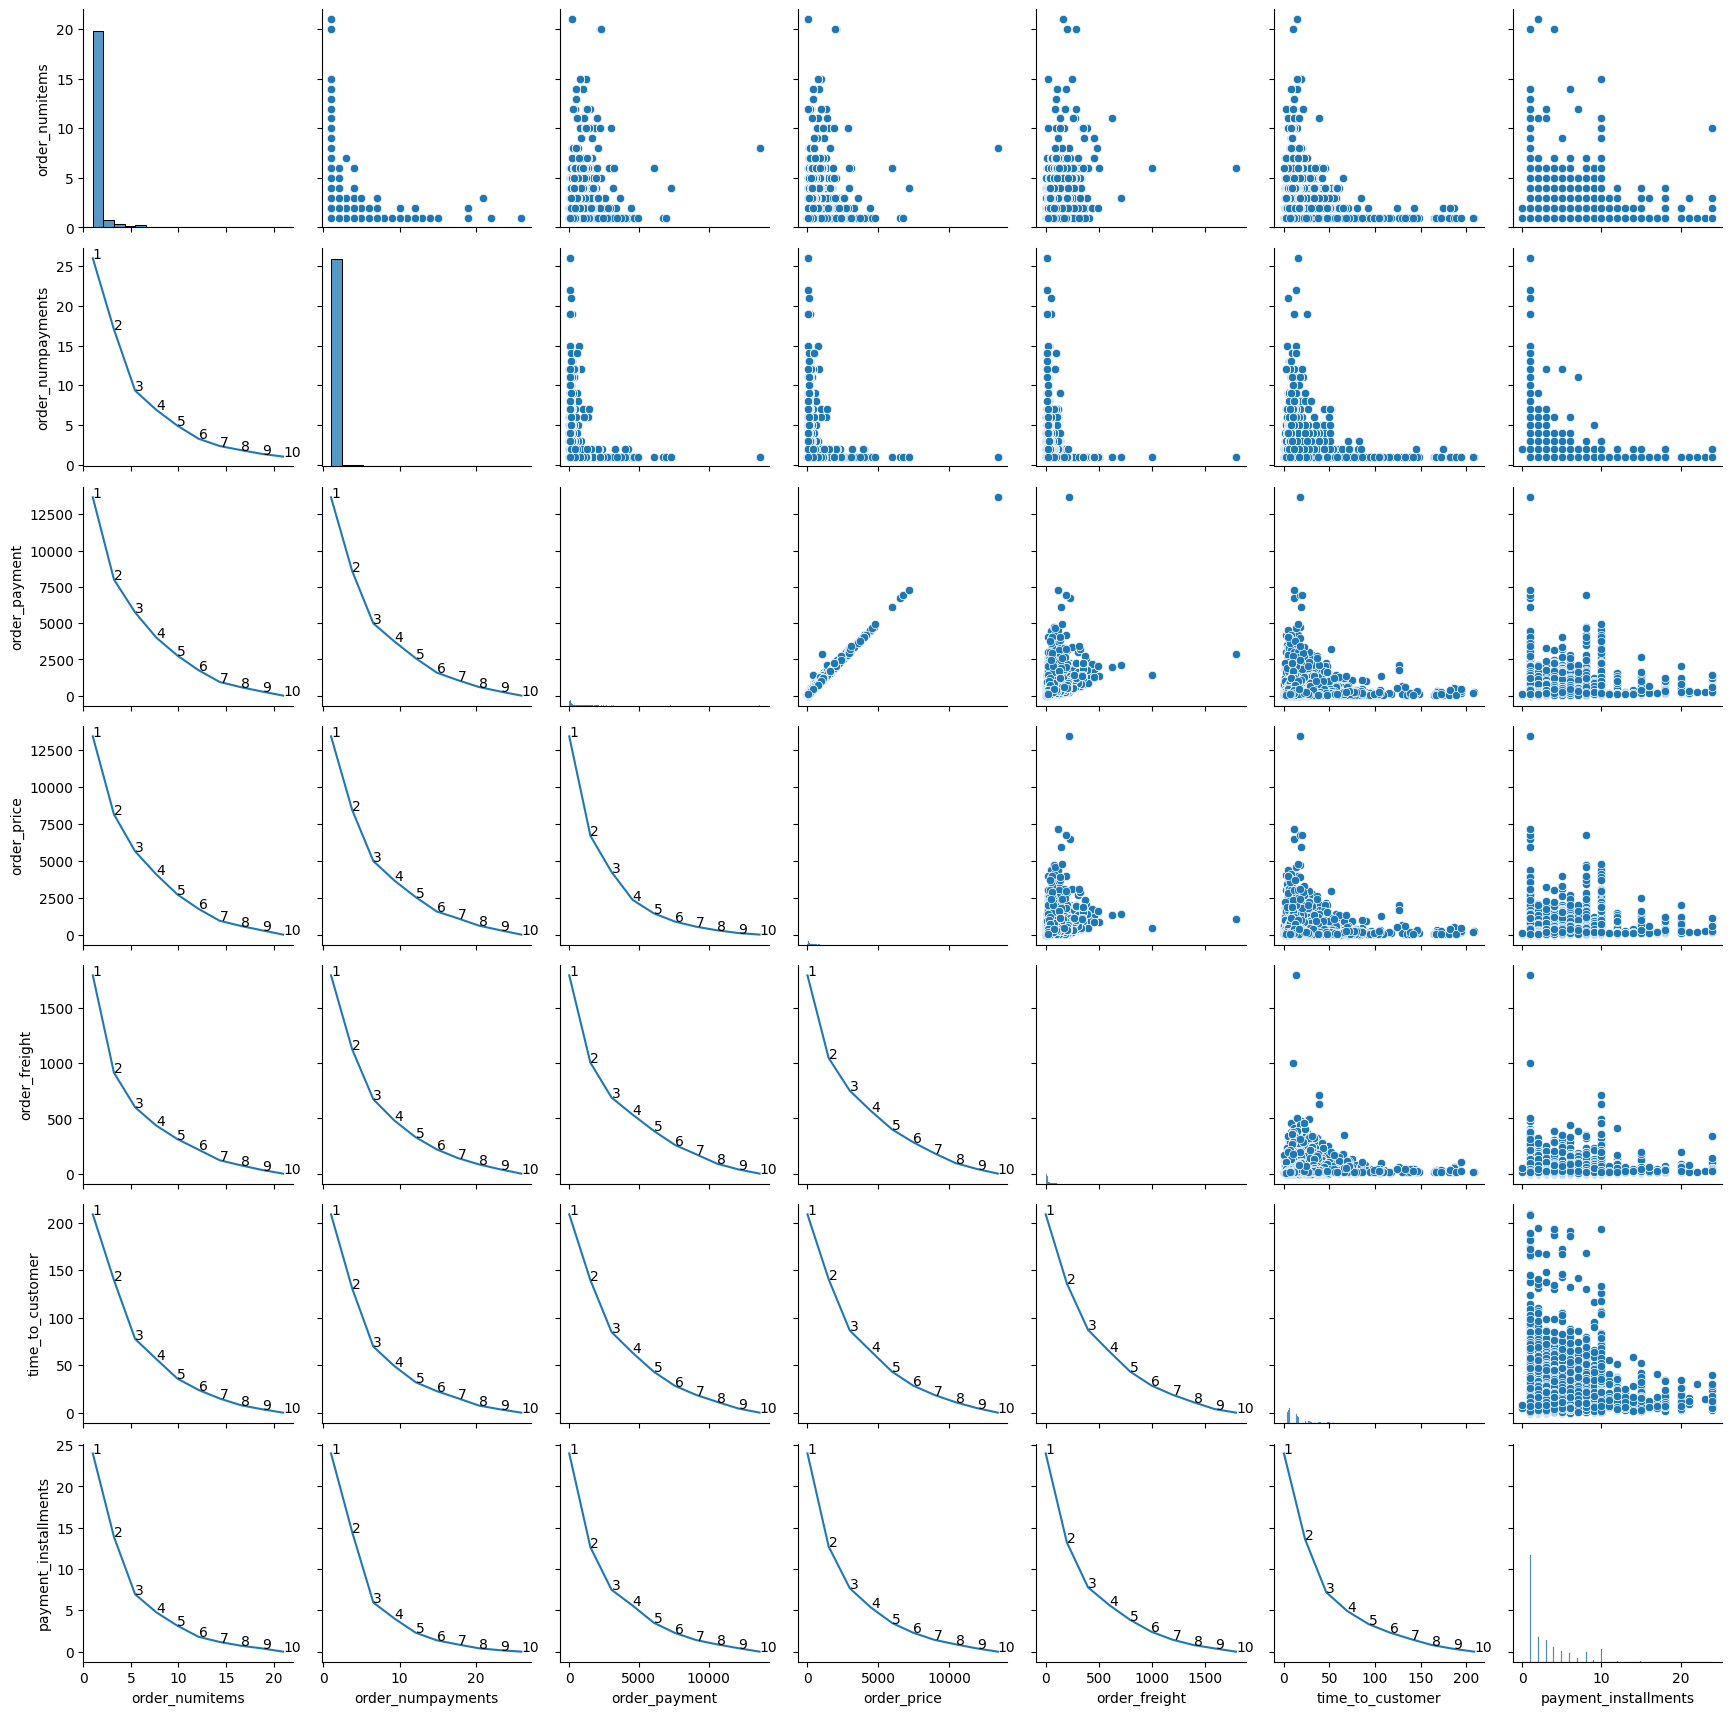

In [14]:
g = sns.PairGrid(df_order)
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(kmeans_elbow_xy)

## 3.3 Visualize Results [(#)](#0-table-of-contents)

`time_to_customer` and `order_payment` seems to be a pair where KMeans is applicable

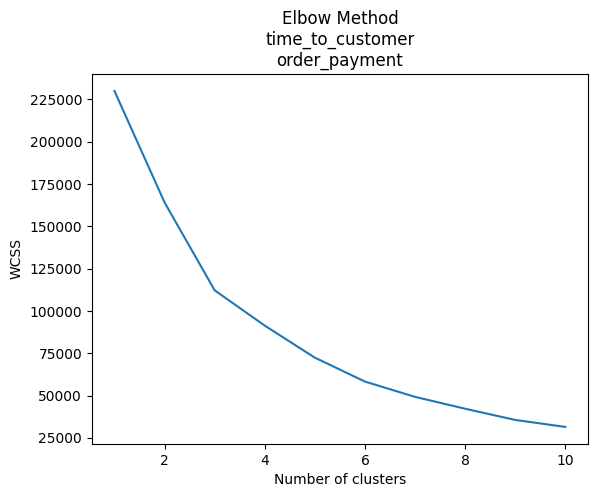

In [25]:
kmeans_elbow(df_order[["time_to_customer", "order_payment"]])

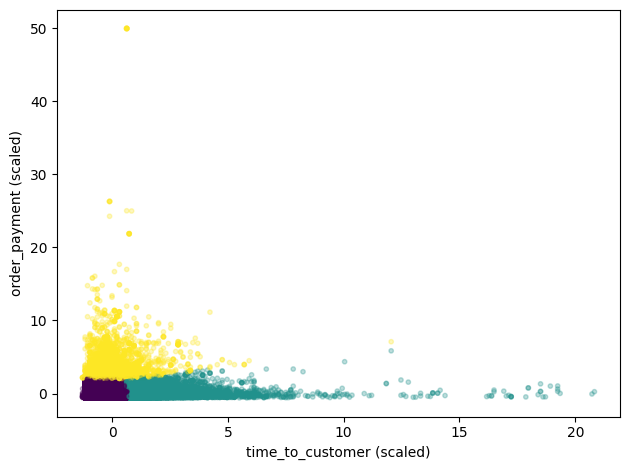

In [16]:
kmeans_show(df_order[["time_to_customer", "order_payment"]], 3)

Here is an example of KMeans applied to multiple varaible at once

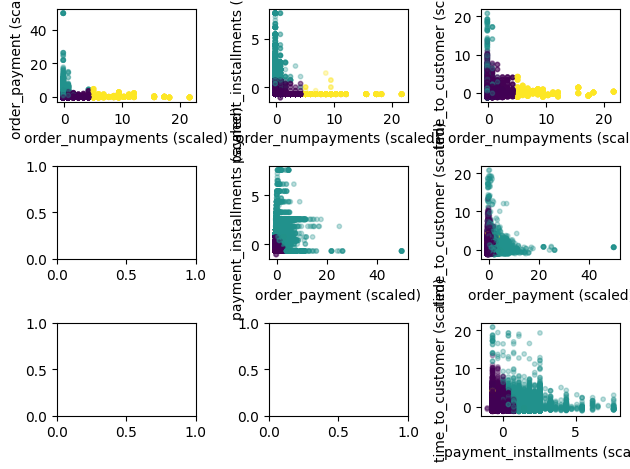

In [26]:
kmeans_show(df_order[["order_numpayments", "order_payment", "payment_installments", "time_to_customer"]],3)